In [ ]:
# tensorflow
from keras.models import Sequential, Model, load_model
from keras.layers import UpSampling2D, Conv2D, Activation, BatchNormalization, \
                        Reshape, Dense, Input, LeakyReLU, ReLU, Dropout, Flatten, ZeroPadding2D, \
                        Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow_datasets as tfds
import tensorflow as tf

# others
import numpy as np
import os
from imageio import imwrite
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import cv2 as cv
import pandas as pd
import shutil
from IPython import display
import time
from functools import cmp_to_key
from statistics import mean
%matplotlib inline

In [ ]:
# turn on acceleration
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


2022-05-05 17:23:55.534571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:23:55.635125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:23:55.635933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [ ]:
# all used filepaths
discriminator_path = "data/models/discrim.h5"
generator_path = "data/models/generat.h5"
output_path = "data/output/test"
input_path = '../input/abstract-art-gallery/Abstract_gallery'
path_history = f"{output_path}/history.csv"
path_gallery = f"{output_path}/gallery_generated_"
save_path = output_path + "/models"

In [ ]:
def save_history(d_loss, d_acc, g_loss):
    history = pd.DataFrame({'Discriminator loss': [d_loss],
                           'Discriminator accuracy x100': [d_acc],
                           'Generator loss': [g_loss]})
    history.to_csv(path_history, mode='a', header=not os.path.exists(save_path))

In [ ]:
def save_imgs(epoch, imgs, gallery_size, img_size):
    imgs = 0.5 * imgs + 0.5
    
    # individual images
    for i, img_array in enumerate(imgs):
        path = f"{output_path}/generated_{img_size[0]}x{img_size[1]}"
        if not os.path.exists(path):
            os.makedirs(path)
        imwrite(path + f"/{epoch}_{i}.png", img_array)
    
    # gallery of images
    nindex, height, width, intensity = imgs.shape
    nrows = nindex // gallery_size[1]
    assert nindex == nrows * gallery_size[1]
    # want result.shape = (height*nrows, width*ncols, intensity)
    gallery = (imgs.reshape(nrows, gallery_size[1], height, width, intensity)
              .swapaxes(1, 2)
              .reshape(height * nrows, width * gallery_size[1], intensity))

    path = f"{output_path}/gallery_generated_{img_size[0]}x{img_size[1]}"
    if not os.path.exists(path):
        os.makedirs(path)
    imwrite(path + f"/{epoch}.png", gallery)

In [ ]:
def sort_filenames(x1, x2):
    n1 = int(x1[:-4])
    n2 = int(x2[:-4])
    return n1 - n2

In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 0
KERNEL_SIZE = 4
CHANNELS = 3
EPOCHS = 200
SAVE_INTERVAL = 25
NOISE_DIM = 100

## DCGAN Implementation

In [ ]:
# for 128 x 128 image size
def build_generator(kernel_size, noise_shape=(NOISE_DIM,), summary=True):
    model = Sequential(name='Generator')
    
    model.add(Dense(4*4*64, input_shape=noise_shape))
    model.add(Reshape((4, 4, 64)))
    
    model.add(BatchNormalization())
    model.add(UpSampling2D())
    model.add(Conv2D(1024, kernel_size, strides=(1,1), padding='same'))
    
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(UpSampling2D())
    model.add(Conv2D(512, kernel_size, strides=(1,1), padding='same'))
    
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size, strides=(1,1), padding='same'))
    
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size, strides=(1,1), padding='same'))
    
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size, strides=(1,1), padding='same'))
    
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size, strides=(1,1), padding='same'))
    
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(3, kernel_size, strides=(1,1), padding='same'))
    model.add(Activation("tanh"))
    
    model.build(noise_shape)
    
    if summary:
        model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)

    return Model(inputs=noise, outputs=img, name='Generator')

In [ ]:
def build_discriminator(img_size, channels, kernel_size, summary=True):
    img_shape = (img_size[0], img_size[1], channels)

    model = Sequential(name='Discriminator')

    model.add(Conv2D(32, kernel_size=kernel_size, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=kernel_size, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(128, kernel_size=kernel_size, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(256, kernel_size=kernel_size, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=kernel_size, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    if summary:
        model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(inputs=img, outputs=validity, name='Discriminator')

2022-05-05 17:23:55.763839: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-05 17:23:55.764182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:23:55.764940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:23:55.765598: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Decision: [[0.499162]]


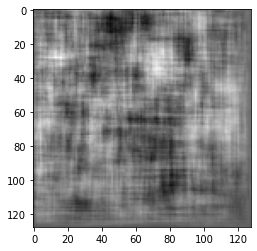

In [ ]:
test_generator = build_generator(kernel_size=4, summary=False)
test_discriminator = build_discriminator(IMG_SIZE, channels=3, kernel_size=4, summary=False)
noise = tf.random.normal([1, NOISE_DIM])
test_image = test_generator(noise, training=False)
plt.imshow(test_image[0,:,:,0], cmap='gray')
decision = test_discriminator(test_image)
print(f"Decision: {decision}")

## Loading dataset

In [ ]:
def load_imgs(image_path, img_size, batch_size):
    dataset = image_dataset_from_directory(image_path, image_size=img_size, batch_size=batch_size)
    example_batch = dataset.take(1)
    plt.figure(figsize=(10,10))
    for images, labels in example_batch:
        for i in range(32):
            ax = plt.subplot(4, 8, i + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(images[i].numpy().astype("uint8"))
    return dataset

In [ ]:
def preprocess_imgs(dataset):
    normalization = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)
    dataset = dataset.map(lambda x, y: (normalization(x), y))
    dataset = tfds.as_numpy(dataset)
    X_train = []
    for batch in dataset:
        X_train.append(batch[0])
    X_train = np.concatenate(X_train, axis=0)
    return np.asarray(X_train)

In [ ]:
def preprocess_imgs_to_dataset(dataset, batch_size):
    normalization = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)
    dataset = dataset.map(lambda x, y: (normalization(x), y))
#     dataset = dataset.shuffle(len(dataset), seed=SEED)
    dataset = dataset.unbatch()
    return dataset.batch(batch_size)

Found 2782 files belonging to 1 classes.


2022-05-05 17:24:05.143085: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


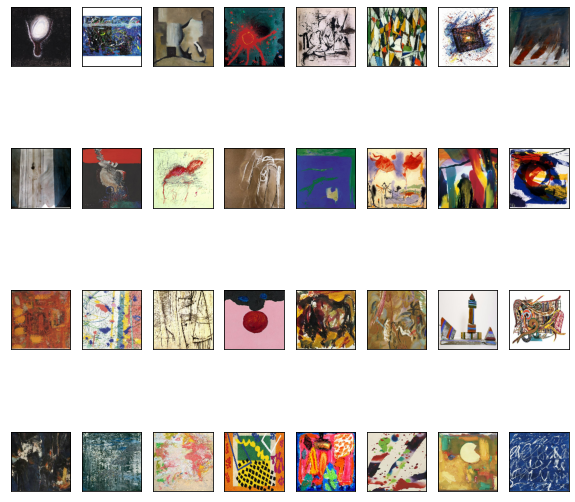

In [ ]:
dataset = load_imgs(input_path, IMG_SIZE, BATCH_SIZE)

In [ ]:
train_dataset = preprocess_imgs_to_dataset(dataset, BATCH_SIZE)
train_dataset

<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
X_train = preprocess_imgs(dataset)
print("Training Data Shape: ", X_train.shape)
X_train[1]

## Building model

In [ ]:
# cross_entropy = BinaryCrossentropy(from_logits=True)
cross_entropy = BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
gan_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
if os.path.exists(discriminator_path) and os.path.exists(generator_path):
    discriminator = load_model(discriminator_path)
    generator = load_model(generator_path)
    print("Loaded models...")
else:
    print("No saved models were found")
    generator = build_generator(KERNEL_SIZE)
    generator.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
    discriminator = build_discriminator(IMG_SIZE, CHANNELS, KERNEL_SIZE)
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=discriminator_optimizer,
                               metrics=['accuracy'])

No saved models were found
Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              103424    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 4, 4, 64)          256       
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 1024)        1049600   
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 8, 8, 1024)        0         
_________________________________________________________________
batch_normalization_19 (Batc (

In [ ]:
# @tf.function
def train_step(images, batch_size, noise_dim):
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images[0], training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return disc_loss, gen_loss


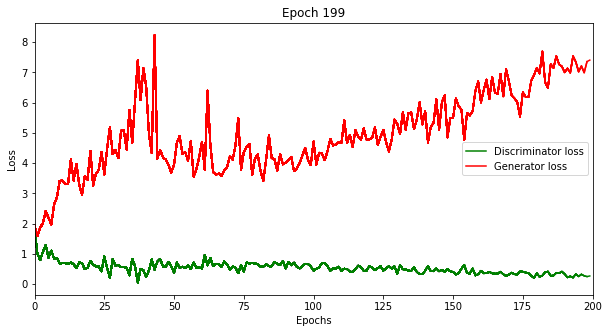

In [ ]:
d_losses = []
g_losses = []
d_losses_per_epoch = []
g_losses_per_epoch = []
epochs_range = []
figure, ax = plt.subplots(figsize=(10,5))
d_line = ax.plot(epochs_range, d_losses, 'g-', label='Discriminator loss')
g_line = ax.plot(epochs_range, g_losses, 'r-', label='Generator loss')
ax.set_xlim(0,EPOCHS)
ax.legend()

plt.xlabel("Epochs")
plt.ylabel("Loss")
i = 0
if not os.path.exists(save_path):
    os.makedirs(save_path)
        
for epoch in range(EPOCHS):
    start = time.time()
    d_losses_per_epoch = []
    g_losses_per_epoch = []
    epochs_range.append(epoch)
    
    for image_batch in train_dataset:
        disc_loss, gen_loss = train_step(image_batch, BATCH_SIZE, NOISE_DIM)
        d_losses_per_epoch.append(disc_loss.numpy())
        g_losses_per_epoch.append(gen_loss.numpy())
    
    d_losses.append(mean(d_losses_per_epoch))
    g_losses.append(mean(g_losses_per_epoch))
    # Plot the loss
    print("Plotting...")
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    d_line = ax.plot(epochs_range, d_losses, 'g-', label='Discriminator loss')
    g_line = ax.plot(epochs_range, g_losses, 'r-', label='Generator loss')
    ax.set_title(f"Epoch {epoch}")
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if epoch % (SAVE_INTERVAL) == 0:
        gallery_size = (5, 5)
        noise = np.random.normal(0, 1, (gallery_size[0]*gallery_size[1], NOISE_DIM))
        imgs_to_save = generator.predict(noise)
        
        save_imgs(epoch, imgs_to_save, gallery_size, IMG_SIZE)

        discriminator.save(save_path + "/discrim.h5")
        generator.save(save_path + "/generat.h5")
    
    save_history(mean(d_losses_per_epoch), 1-mean(d_losses_per_epoch), mean(g_losses_per_epoch))


In [ ]:
d_losses

In [ ]:
half_batch = BATCH_SIZE // 2

d_losses = []
g_losses = []
epochs_range = []
figure, ax = plt.subplots(figsize=(10,5))
d_line = ax.plot(epochs_range, d_losses, 'g-', label='Discriminator loss')
g_line = ax.plot(epochs_range, g_losses, 'r-', label='Generator loss')
ax.set_xlim(0,EPOCHS *)
ax.legend()

plt.xlabel("Epochs")
plt.ylabel("Loss")

for epoch in range(EPOCHS):


    # Train Generator
    noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM))
    g_loss = dcgan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

    # Train Discriminator
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]
    print(f"Trained on idx: {idx}")

    # Sample noise and generate a half batch of new images
    noise = np.random.normal(0, 1, (half_batch, NOISE_DIM))
    gen_imgs = generator.predict(noise)

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_losses.append(d_loss[0])
    g_losses.append(g_loss)
    epochs_range.append(epoch)
    
    # Plot the loss
    print("Plotting...")
    d_line = ax.plot(epochs_range, d_losses, 'g-', label='Discriminator loss')
    g_line = ax.plot(epochs_range, g_losses, 'r-', label='Generator loss')
    ax.set_title(f"Epoch {epoch}")
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    # Save images and history of loss
    if epoch % (SAVE_INTERVAL) == 0:
        gallery_size = (5, 5)
        noise = np.random.normal(0, 1, (gallery_size[0]*gallery_size[1], NOISE_DIM))
        imgs_to_save = generator.predict(noise)
        
        save_imgs(epoch, imgs_to_save, gallery_size, IMG_SIZE)

        save_path = output_path + "/models"
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        discriminator.save(save_path + "/discrim.h5")
        generator.save(save_path + "/generat.h5")

    save_history(d_loss[0], d_loss[1], g_loss)

## View results

In [ ]:
df = pd.read_csv(path_history)
df = df.rename(columns={df.columns[1]: "Discriminator loss",
               df.columns[2]: "Discriminator accuracy x100",
               df.columns[3]: "Generator loss"})
df.drop('0', axis=1, inplace=True)
df

,Discriminator loss,Discriminator accuracy x100,Generator loss
0,1.024258,-0.024258,1.580322
1,0.785815,0.214185,1.856986
2,1.071848,-0.071848,2.019813
3,1.286640,-0.286640,2.412551
4,0.875060,0.124940,2.189710
...,...,...,...
194,0.253049,0.746951,7.022587
195,0.321365,0.678635,7.205597
196,0.271616,0.728384,6.991511
197,0.247045,0.752955,7.354777


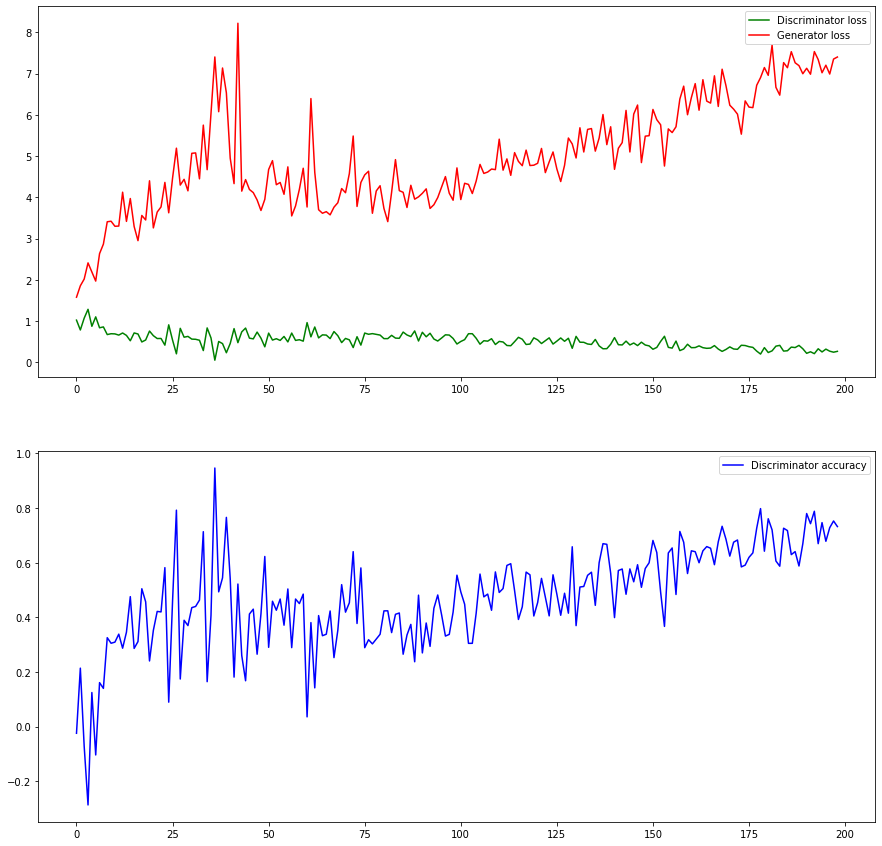

In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(2, figsize=(15,15))
ax_loss.plot(df["Discriminator loss"], 'g-', label='Discriminator loss')
ax_loss.plot(df["Generator loss"], 'r-', label='Generator loss')
ax_loss.legend()
ax_acc.plot(df["Discriminator accuracy x100"], 'b-', label='Discriminator accuracy')
ax_acc.legend()

In [ ]:
path_gallery_size = path_gallery + f"{IMG_SIZE[0]}x{IMG_SIZE[1]}"
img_names = os.listdir(path_gallery_size)
img_names.sort(key=cmp_to_key(sort_filenames))
print(f"Number of saved images:{len(img_names)}")
img_names

Number of saved images:8


['0.png',
 '25.png',
 '50.png',
 '75.png',
 '100.png',
 '125.png',
 '150.png',
 '175.png']

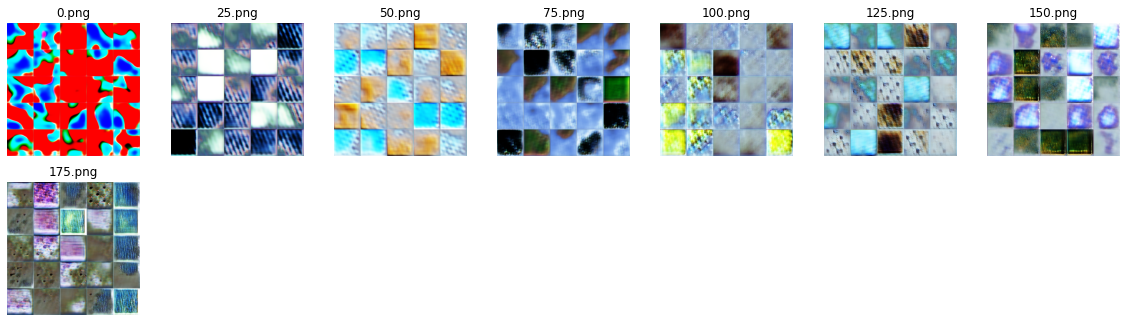

In [ ]:
img_list = []
plt.figure(figsize=(20,20))
for i in range(len(img_names)):
    ax = plt.subplot(7,7,i+1)
    img_path = path_gallery_size+'/'+img_names[i]
    img = cv.imread(img_path)
    img_list.append(img)
    scale_percent = 200 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)    
    cv.resize(img, dim)
    plt.imshow(img)
    plt.axis("off")
    ax.set_title(img_names[i])

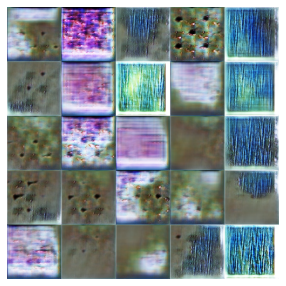

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.axis("off")
ims = [[plt.imshow(img, animated=True)] for img in img_list]
gif = animation.ArtistAnimation(fig, ims, interval=250, repeat_delay=250, blit=True)

display.HTML(gif.to_jshtml())

## Generate new images

<Figure size 720x720 with 0 Axes>

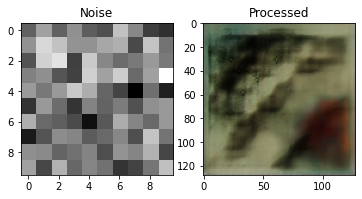

In [ ]:
noise = np.random.normal(0, 1, (1, NOISE_DIM))
plt.figure(figsize=(10,10))
fig, axes = plt.subplots(1,2)
generated = generator.predict(noise)
generated = generated * 0.5 + 0.5

noise = noise.reshape(10,10)
noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))
axes[0].imshow(noise, cmap='gray')
axes[0].set_title("Noise")
axes[1].set_title("Processed")
axes[1].imshow(generated[0])

## Clean up

In [ ]:
shutil.rmtree("data/output/test")

In [ ]:
os.path.exists("data/output/test")

False